In [ ]:
pip install transformers

In [ ]:
pip install nltk

In [ ]:
import numpy as np
import pandas as pd
import transformers
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, TFDistilBertModel,TFDistilBertForSequenceClassification,TFBertForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import re
import unicodedata
from tensorflow import keras
import pickle
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
import itertools
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
print('importing done')

importing done


In [ ]:
nltk.download('stopwords')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_file='/content/drive/MyDrive/machine learning/spam.csv'
data=pd.read_csv(data_file,encoding='ISO-8859-1')
data=data[['v1','v2']].rename(columns={"v1": "target", "v2": "text"}) #As dataset consists of unwanted columns, thereby considering only those columns which has required information
                                                                      # renaming the column names to target and text
print('printing top5 rows and columns\n')
print(data.head()) 
print('\n Dataset consists of {} datapoints and {} coloumns'.format(data.shape[0],data.shape[1]))

printing top5 rows and columns

  target                                               text
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...

 Dataset consists of 5572 datapoints and 2 coloumns


In [ ]:
print('Checking if there are any null values\n')
print(data.isnull().sum())                                                   #checking if there are any NaN values in the dataset
data=data.reset_index(drop=True)                                             # Reset index after dropping the columns/rows with NaN values
data = shuffle(data)                                                         # Shuffle the dataset
print('\n Available labels: ',data['target'].unique())

Checking if there are any null values

target    0
text      0
dtype: int64

 Available labels:  ['ham' 'spam']


visualizing the target feature to check if there are any imbalance 



<BarContainer object of 2 artists>

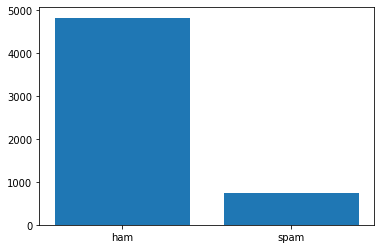

In [ ]:
print('visualizing the target feature to check if there are any imbalance \n')
plt.bar(data['target'].unique(), data['target'].value_counts() )

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    
def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [ ]:
data['text']=data['text'].map(preprocess_sentence) 

The max length in the complete text is: text


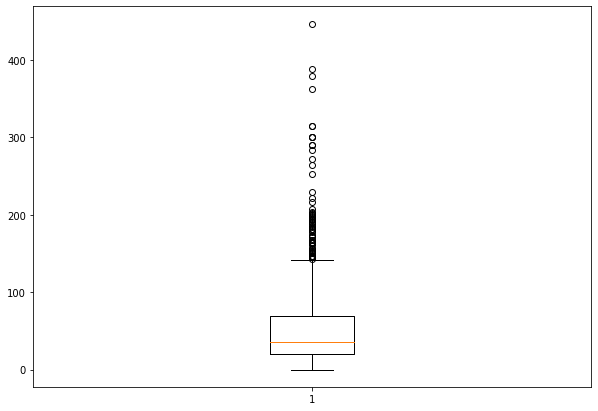

In [ ]:
length=[]
for sent in data['text'].values:    #Checking the max_length of a sentence in training dataset as it is necessary to pad the remaining sentence. 
  length.append(len(sent))
print('The max length in the complete text is:', max(data))
fig = plt.figure(figsize =(10, 7))             
plt.boxplot(length)   # Creating plot 
plt.show()

(array([9.21433630e-03, 1.91875003e-02, 1.14065052e-02, 6.85353903e-03,
        5.91403807e-03, 5.96221761e-03, 4.52887641e-03, 2.39693193e-03,
        6.38378855e-04, 2.89077217e-04, 1.68628377e-04, 9.63590724e-05,
        1.32493725e-04, 1.08403957e-04, 2.40897681e-05, 1.20448841e-05,
        1.20448841e-05, 1.20448841e-05, 1.20448841e-05, 3.61346522e-05,
        3.61346522e-05, 2.40897681e-05, 0.00000000e+00, 0.00000000e+00,
        1.20448841e-05, 1.20448841e-05, 1.20448841e-05, 0.00000000e+00,
        0.00000000e+00, 1.20448841e-05]),
 array([  0. ,  14.9,  29.8,  44.7,  59.6,  74.5,  89.4, 104.3, 119.2,
        134.1, 149. , 163.9, 178.8, 193.7, 208.6, 223.5, 238.4, 253.3,
        268.2, 283.1, 298. , 312.9, 327.8, 342.7, 357.6, 372.5, 387.4,
        402.3, 417.2, 432.1, 447. ]),
 <a list of 30 Patch objects>)

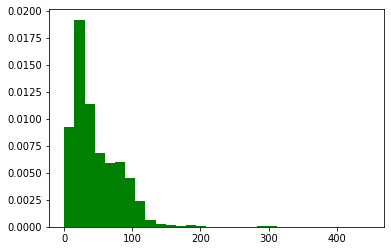

In [ ]:
plt.hist(length,bins=30,density = 1,color ='green')

In [ ]:
num_classes=len(data['target'].unique())

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

bert_model= TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sent= 'This is an example statement to show, how the bert tokenize the words '
tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =100,padding=True,
return_attention_mask = True)

In [ ]:
print("The orginal sentence:", sent)
print('\n The tokenized sentence:',bert_tokenizer.tokenize(sent))
bert_tokens=bert_tokenizer.encode(sent)
print("\n The encoded sentence using bert:", bert_tokens)
print("\n The decoded sentence after bert encoder:", bert_tokenizer.decode(bert_tokens))
print("\n encoded -----> decoded \n")
for i in bert_tokens:
  print(str(i)+ '----->' + bert_tokenizer.decode(i))
print(tokenized_sequence)

The orginal sentence: This is an example statement to show, how the bert tokenize the words 

 The tokenized sentence: ['this', 'is', 'an', 'example', 'statement', 'to', 'show', ',', 'how', 'the', 'bert', 'token', '##ize', 'the', 'words']

 The encoded sentence using bert: [101, 2023, 2003, 2019, 2742, 4861, 2000, 2265, 1010, 2129, 1996, 14324, 19204, 4697, 1996, 2616, 102]

 The decoded sentence after bert encoder: [CLS] this is an example statement to show, how the bert tokenize the words [SEP]

 encoded -----> decoded 

101----->[ C L S ]
2023----->t h i s
2003----->i s
2019----->a n
2742----->e x a m p l e
4861----->s t a t e m e n t
2000----->t o
2265----->s h o w
1010----->,
2129----->h o w
1996----->t h e
14324----->b e r t
19204----->t o k e n
4697-----># # i z e
1996----->t h e
2616----->w o r d s
102----->[ S E P ]
{'input_ids': [101, 2023, 2003, 2019, 2742, 4861, 2000, 2265, 1010, 2129, 1996, 14324, 19204, 4697, 1996, 2616, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
data['target_num'] = data['target'].map({'ham':0,'spam':1})
print(data.head())
sentences=data['text']
labels=data['target_num']
len(sentences),len(labels)

     target                                               text  target_num
2369    ham  boy loved gal propsd didnt mind lttrs frnds th...           0
3720    ham                          blank blank wat blank lol           0
933     ham                   time think need know near campus           0
4676    ham                                        wewa iriver           0
3385    ham       oops mum somerset bit far back tomo see soon           0


(5572, 5572)

In [ ]:
input_ids=[]
attention_masks=[]
for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =100,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
len(input_ids),len(attention_masks),len(labels)

(5572, 5572, 5572)

In [ ]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (4457, 100) Val input shape (1115, 100)
Train label shape (4457,) Val label shape (1115,)
Train attention mask shape (4457, 100) Val attention mask shape (1115, 100)


In [ ]:
input_ids_in = tf.keras.layers.Input(shape=(100,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(100,), name='masked_token', dtype='int32') 
    
embedding_layer = bert_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Dropout(0.2)(embedding_layer)
X = tf.keras.layers.Dense(2, activation='sigmoid')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)
model.compile(optimizer=optimizer, loss=loss, metrics=metric)
    
    

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica TFSequenceClassifier 109483778   input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
dropout_156 (Dropout)           (None, 2)            0           tf_bert_for_sequence_classi

In [ ]:
filepath='/content/drive/MyDrive/machine learning_2/models/bert_model-{epoch:02d}.hdf5'
save=ModelCheckpoint(filepath,monitor='val_loss',verbose=0,save_best_only=True,save_weights_only=True, mode='auto')
callbacks = [save]

In [ ]:
history = model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=5,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/5
140/140 [==============================] - 90s 645ms/step - loss: 0.0731 - accuracy: 0.9856 - val_loss: 0.0739 - val_accuracy: 0.9767
Epoch 2/5
140/140 [==============================] - 90s 645ms/step - loss: 0.0581 - accuracy: 0.9874 - val_loss: 0.0695 - val_accuracy: 0.9767
Epoch 3/5
140/140 [==============================] - 90s 645ms/step - loss: 0.0420 - accuracy: 0.9886 - val_loss: 0.0705 - val_accuracy: 0.9857
Epoch 4/5
140/140 [==============================] - 90s 643ms/step - loss: 0.0373 - accuracy: 0.9939 - val_loss: 0.0728 - val_accuracy: 0.9865
Epoch 5/5
140/140 [==============================] - 90s 643ms/step - loss: 0.0318 - accuracy: 0.9928 - val_loss: 0.1246 - val_accuracy: 0.9821


In [ ]:
def plt_train_val_acc(x,val_acc,train_acc,colors=['b']):
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(x,val_acc,'b',label="Validation Accuracy")
    plt.plot(x,train_acc,'r',label="Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy after each epoch')
    plt.legend()
    
def plt_train_val_loss(x,val_loss,train_loss,colors=['b']):
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(x,val_loss,'b',label="Validation Loss")
    plt.plot(x,train_loss,'r',label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel('Binary Crossentropy loss')
    plt.legend()

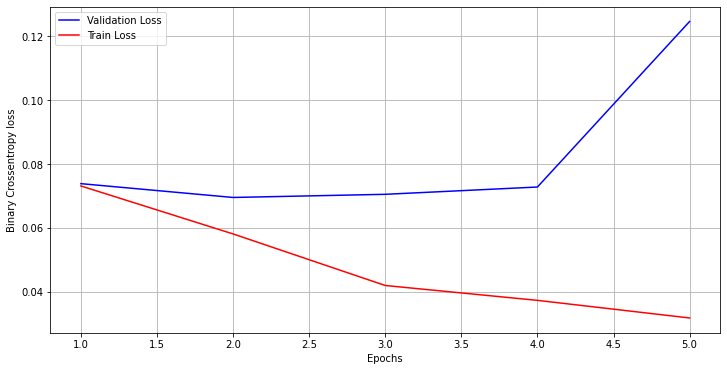

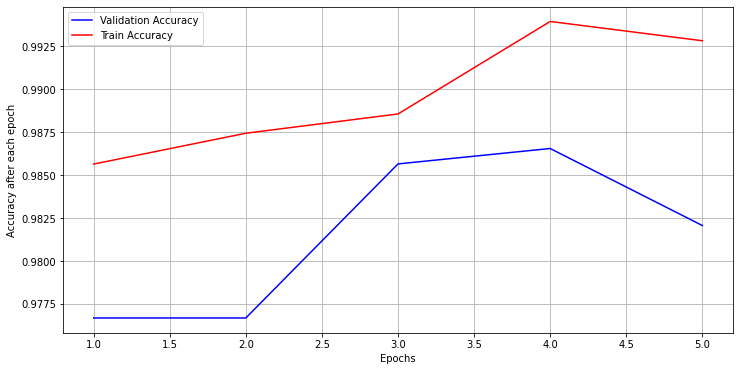

In [ ]:
epochs=5
history=model.history
x=list(range(1,epochs+1))
val_loss=history.history['val_loss']
train_loss=history.history['loss']
plt_train_val_loss(x,val_loss,train_loss)

val_acc=history.history['val_accuracy']
train_acc=history.history['accuracy']
plt_train_val_acc(x,val_acc,train_acc)

In [ ]:
preds=model.predict([val_inp,val_mask],batch_size=32)
pred_labels = preds.argmax(axis=1)
f1 = f1_score(val_label,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels,target_names=['ham','spam']))
print('Training and saving built model.....')

F1 score 0.9324324324324325
Classification Report
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       960
        spam       0.98      0.89      0.93       155

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Training and saving built model.....


In [ ]:
sent1= 'free entry wkly comp win cup final tkts may text receive entry question std txt rate apply'
input_ids_1=[]
attention_masks_1=[]
for sent in sent1:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =100,pad_to_max_length = True,return_attention_mask = True)
    input_ids_1.append(bert_inp['input_ids'])
    attention_masks_1.append(bert_inp['attention_mask'])

input_ids_1=np.asarray(input_ids_1)
attention_masks_1=np.array(attention_masks_1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
tf_output=model.predict([input_ids_1,attention_masks_1])[0]                     

In [ ]:
if tf_output[0]>tf_output[1]:
  print('This is a postive statement')
else:
  print('This is a Negative statement')

This is a postive statement
